##Import Libraries

In [4]:
# Library to support working with data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from functools import partial
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from functools import partial
from keras.layers import GRU, Dropout, Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error

##Data preprocessing

###Read data

In [5]:
# Load data
df = pd.read_csv('./data/NTR.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,46.209999,46.990002,45.855000,46.259998,40.076595,1289100
1,2019-01-03,46.000000,46.099998,44.882999,45.049999,39.028339,1158800
2,2019-01-04,45.950001,47.180000,45.880001,47.130001,40.830315,1538500
3,2019-01-07,47.310001,48.110001,46.840000,47.740002,41.358772,954700
4,2019-01-08,48.709999,49.480000,48.520000,49.209999,42.632286,1921800
...,...,...,...,...,...,...,...
1114,2023-06-06,53.000000,57.294998,52.820000,57.220001,57.220001,6397900
1115,2023-06-07,57.610001,59.750000,57.520000,59.340000,59.340000,2925500
1116,2023-06-08,59.400002,60.080002,57.910000,58.939999,58.939999,2828400
1117,2023-06-09,58.959999,59.349998,58.290001,58.790001,58.790001,1686600


###Reset index

In [6]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [7]:
# Select the Close column as the dependent variable
df_Close = df[['Close']]
#df_Close = df_Close.dropna() # Drop missing values
df_Close = df_Close.reset_index(drop=True) # Reset the index
df_Close.head(20)

,Close
0,46.259998
1,45.049999
2,47.130001
3,47.740002
4,49.209999
5,49.410000
6,50.049999
7,49.869999
8,49.680000
9,49.669998


###Data normalization

In [8]:
# Scaling the data
scaler=MinMaxScaler(feature_range=(0,1))
data_scaled=scaler.fit_transform(df_Close)
data_scaled

array([[0.23668902],
       [0.22315435],
       [0.24642059],
       ...,
       [0.37852348],
       [0.37684565],
       [0.38601791]])

###Data splitting

In [9]:
# Split the data into training, validation and test dataset in a ratio of 6:2:2
train_size = int(0.6 * len(data_scaled))
val_size = int(0.2 * len(data_scaled))
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]

###Define Model and find the Best Model on the Training and Validation Sets

In [10]:
#define
units_values = [50, 100, 150, 200]
dropout_values = [0.1, 0.2, 0.3, 0.4, 0.5]
optimizer_values = ['adam', 'rmsprop', 'sgd']

#define param_distributions
param_distributions = {
    'units': units_values,
    'dropout': dropout_values,
    'optimizer': optimizer_values
}

#define time_step
time_step_grid = [30, 50, 60, 70, 100]


best_mape = float('inf')
best_model = None
best_params = None
best_time_step = None

In [11]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step, prev_data=None):
    dataX, dataY = [], []
    start_index = 0

    # If previous data is available
    if prev_data is not None:
        start_index = max(0, time_step - len(prev_data))
        dataset = np.concatenate((prev_data, dataset))

    for i in range(start_index, len(dataset)-time_step):
        dataX.append(dataset[i:(i+time_step), 0])
        dataY.append(dataset[i + time_step, 0])

    return np.array(dataX), np.array(dataY)

In [12]:
def create_model(time_step, units, dropout, optimizer):
    # Define GRU model with current parameters
    model = Sequential()
    model.add(GRU(units, input_shape=(time_step, 1)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [13]:
for time_step in time_step_grid:
    print(f"Starting evaluation for time_step: {time_step}")

    X_train, y_train = create_dataset(train_data, time_step)
    last_points_train = train_data[-time_step:]
    X_val, y_val = create_dataset(val_data, time_step, last_points_train)

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

    model = KerasRegressor(build_fn=create_model, time_step=time_step, epochs=100, batch_size=64, verbose=0)

    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, n_iter=10, cv=3)
    random_search.fit(X_train, y_train)

    current_model = random_search.best_estimator_.model

    # early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    current_model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[early_stopping])

    predictions = current_model.predict(X_val)
    mape = mean_absolute_percentage_error(y_val, predictions)

    print(f"Validation MAPE for time_step {time_step}: {mape}")
    print(f"Best parameters for time_step {time_step}: {random_search.best_params_}")

    if mape < best_mape:
        best_mape = mape
        best_model = current_model
        best_params = random_search.best_params_
        best_time_step = time_step
# Print the best overall parameters and score.
print("---------------------------------------")
print(f"Best overall MAPE: {best_mape}")
print(f"Best overall parameters: {best_params}")
print(f"Best overall time_step: {best_time_step}")

Starting evaluation for time_step: 30
7/7 [==============================] - 0s 2ms/step
Validation MAPE for time_step 30: 0.0336364620807183
Best parameters for time_step 30: {'units': 100, 'optimizer': 'adam', 'dropout': 0.1}
Starting evaluation for time_step: 50
7/7 [==============================] - 0s 3ms/step
Validation MAPE for time_step 50: 0.032819142258971604
Best parameters for time_step 50: {'units': 150, 'optimizer': 'rmsprop', 'dropout': 0.2}
Starting evaluation for time_step: 60
7/7 [==============================] - 0s 3ms/step
Validation MAPE for time_step 60: 0.046270751956448856
Best parameters for time_step 60: {'units': 50, 'optimizer': 'adam', 'dropout': 0.4}
Starting evaluation for time_step: 70
7/7 [==============================] - 0s 3ms/step
Validation MAPE for time_step 70: 0.03599627512992154
Best parameters for time_step 70: {'units': 200, 'optimizer': 'adam', 'dropout': 0.3}
Starting evaluation for time_step: 100
7/7 [==============================] - 0s 

###Trainning the model with the best parameters.

In [14]:
# Create training, validation and test datasets with the best time_step
X_train, y_train = create_dataset(train_data, best_time_step)

# Reshape input to be [samples, time steps, features] which is required for GRU
last_points_val = train_data[-best_time_step:]
X_val, y_val = create_dataset(val_data, best_time_step, last_points_val)

last_points_test = val_data[-best_time_step:]
X_test, y_test = create_dataset(test_data, best_time_step, last_points_test)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

###Training process

In [15]:
# Create a new model with the best parameters
best_model = create_model(best_time_step, best_params['units'], best_params['dropout'], best_params['optimizer'])

In [16]:
# Define early stopping
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

In [17]:
# Train the model with the full training data (train + validation)
best_model.fit(X_train,y_train, epochs=100, batch_size=64, verbose=1, callbacks=[early_stopping])

Epoch 1/100
10/10 [==============================] - 4s 9ms/step - loss: 0.0160
Epoch 2/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0029
Epoch 3/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0021
Epoch 4/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0014
Epoch 5/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0014
Epoch 6/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0012
Epoch 7/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0010
Epoch 8/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 9/100
10/10 [==============================] - 0s 8ms/step - loss: 8.7221e-04
Epoch 10/100
10/10 [==============================] - 0s 8ms/step - loss: 9.7047e-04
Epoch 11/100
10/10 [==============================] - 0s 7ms/step - loss: 8.8221e-04
Epoch 12/100
10/10 [==============================] - 0s 7ms/step - loss: 7.7164e-04
Epoch 13/100
10/10 [=

In [18]:
# Now use this to make predictions
y_pred_val = best_model.predict(X_val)
y_pred_test = best_model.predict(X_test)

8/8 [==============================] - 0s 2ms/step


###Testing process

In [19]:
# Invert scaling
y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1))
y_pred_val_inv = scaler.inverse_transform(y_pred_val)

y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_test_inv = scaler.inverse_transform(y_pred_test)

In [20]:
val_MAPE = mean_absolute_percentage_error(y_val_inv, y_pred_val_inv)
val_RMSE = mean_squared_error(y_val_inv, y_pred_val_inv, squared=False)
val_MSLE = mean_squared_log_error(y_val_inv, y_pred_val_inv)
print('MAPE on the data val:', val_MAPE)
print('RMSE on the data val:', val_RMSE)
print('MSLE on the data val:', val_MSLE)

MAPE on the data val: 0.02653139478674152
RMSE on the data val: 3.0678842780171567
MSLE on the data val: 0.001185389203487991


In [21]:
test_MAPE = mean_absolute_percentage_error(y_test_inv, y_pred_test_inv)
test_RMSE = mean_squared_error(y_test_inv, y_pred_test_inv, squared=False)
test_MSLE = mean_squared_log_error(y_test_inv, y_pred_test_inv)
print('MAPE on the data test:', test_MAPE)
print('RMSE on the data test:', test_RMSE)
print('MSLE on the data test:', test_MSLE)

MAPE on the data test: 0.024892026928333925
RMSE on the data test: 2.5535141545358235
MSLE on the data test: 0.0010317339938624936


##Predicting the next 30 days

In [22]:
# Convert the last `best_time_step` days of the test data into the appropriate shape for input to the model
x_input = test_data[-best_time_step:].reshape(1, -1, 1)

temp_input = list(x_input[0])

lst_output = []
i = 0
while(i < 30):
    if len(temp_input) > best_time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1, 1)
        y_pred = best_model.predict(x_input)
        print("{} day input {}".format(i, x_input))
        print("{} day output {}".format(i, y_pred))
        temp_input.append(y_pred[0][0])
        temp_input = temp_input[1:]
        lst_output.append(y_pred[0][0])
        i += 1
    else:
        x_input = np.array(temp_input, dtype=np.float32).reshape((1, len(temp_input), 1))
        y_pred = best_model.predict(x_input)
        print("{} day input {}".format(i, x_input))
        print("{} day output {}".format(i, y_pred))
        temp_input.append(y_pred[0][0])
        temp_input = temp_input[1:]
        lst_output.append(y_pred[0][0])
        i += 1


1/1 [==============================] - 0s 20ms/step
0 day input [[[0.545302  ]
  [0.54854584]
  [0.53624165]
  [0.51823264]
  [0.47997764]
  [0.5155481 ]
  [0.53914994]
  [0.5269575 ]
  [0.53523487]
  [0.5350112 ]
  [0.55682325]
  [0.5459732 ]
  [0.53747207]
  [0.52572703]
  [0.5091723 ]
  [0.51599556]
  [0.49642062]
  [0.49183446]
  [0.49105147]
  [0.49552575]
  [0.5005593 ]
  [0.48847872]
  [0.4692394 ]
  [0.4268456 ]
  [0.44675615]
  [0.44071588]
  [0.43333334]
  [0.4279642 ]
  [0.40984342]
  [0.38914987]
  [0.41521254]
  [0.41342282]
  [0.40268454]
  [0.4067114 ]
  [0.4121924 ]
  [0.40111855]
  [0.39328858]
  [0.36442953]
  [0.34977627]
  [0.34440714]
  [0.32807606]
  [0.30872485]
  [0.3168904 ]
  [0.33210292]
  [0.33836687]
  [0.35928413]
  [0.38299775]
  [0.37852347]
  [0.37684566]
  [0.38601792]]]
0 day output [[0.3735511]]
1/1 [==============================] - 0s 20ms/step
1 day input [[[0.54854584]
  [0.53624165]
  [0.51823264]
  [0.47997764]
  [0.5155481 ]
  [0.53914994]
  [

In [23]:
# Invert the scaling
lst_output = scaler.inverse_transform(np.array(lst_output).reshape(-1,1))

print('Predicted closing prices for the next 30 days:')
for i in range(30):
    print(f"{lst_output[i][0]}")

Predicted closing prices for the next 30 days:
58.49546813964844
58.57284927368164
58.56700897216797
58.53109359741211
58.48445129394531
58.43409729003906
58.38255310058594
58.33074188232422
58.27901840209961
58.22751235961914
58.17627716064453
58.12535095214844
58.074745178222656
58.024452209472656
57.97449493408203
57.92485427856445
57.87554931640625
57.826560974121094
57.77789306640625
57.729549407958984
57.68152618408203
57.633811950683594
57.586421966552734
57.539337158203125
57.4925651550293
57.446102142333984
57.39994430541992
57.35409164428711
57.308536529541016
57.26328659057617


##Visualization

In [24]:
# Create a date index for the predicted data
predict_data_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30)

In [25]:
# Before Plotting Data
# Create index for the training, validation and test data
train_data_index = df.index[:train_size]
val_data_index = df.index[train_size : train_size + val_size]
test_data_index = df.index[train_size + val_size:]

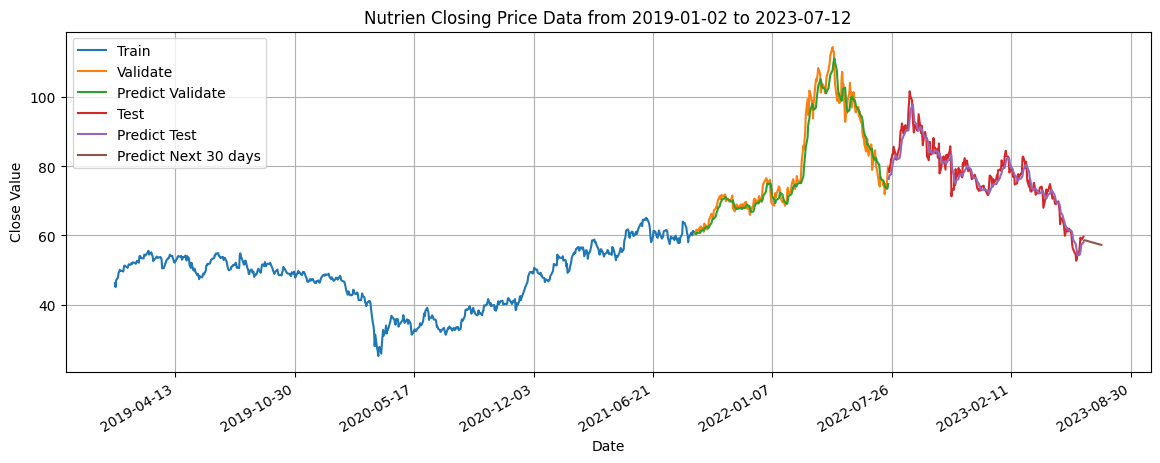

In [26]:
# Begin Plotting Data
plt.figure(figsize=(14, 5))
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')
plt.plot(val_data_index, scaler.inverse_transform(val_data), label='Validate')
plt.plot(val_data_index, y_pred_val_inv, label='Predict Validate')
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')
plt.plot(test_data_index, y_pred_test_inv, label='Predict Test')
plt.plot(predict_data_index, lst_output, label='Predict Next 30 days')

# Set up the date markers on the x-axis
plt.grid()
plt.title(f"Nutrien Closing Price Data from {train_data_index[0].strftime('%Y-%m-%d')} to {predict_data_index[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close Value")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=200)) # Select markers spaced 200 days apart
plt.gcf().autofmt_xdate() # Rotate date labels for better readability
plt.legend()
plt.savefig('./GRU/6_2_2/Image/GRU_622_NTR.png')
plt.show()
